# 2. Markov Chain Monte Carlo (MCMC)

## 2.1. Metropolis-Hastings

It is an algorithm that allows us to sample from a generic probability distribution, which we'll call the target distribution, even if you do not know the normalizing constant. To do this, we construct and sample from a Markov Chain whose stationary distribution is the target distribution that we are looking for. It consists of picking an arbitrary starting value and then iteratively accepting or rejecting candidate samples drawn from another distribution, one that is easy to sample. Let's say we want to produce samples from a target distribution that we are going to call it $Pr(\theta)$, but we only know it up to a normalizing constant or up to proportionality.

$$Pr(\theta) \propto g(\theta)$$

We  do not know the normalizing constant because perhaps it is difficult to integrate. So, we only have $g(\theta)$ to work with. 

The Metropolis-Hasting algorithm will proceed as follows:

1. Select an initial value for $\theta_0$.
2. for i=1..., m,  repeat the following:

    a. Draw candidate sample $\theta^*$ from a proposal distribution $\theta^* \sim  q(\theta^*|\theta_{i-1})$.
    
    b. Compute the acceptance probability $$\alpha = \frac{g(\theta^*) / q(\theta^*|\theta_{i-1})}{g(\theta_{i-1}) / q(\theta_{i-1} | \theta^*)} = \frac{g(\theta^*) q(\theta_{i-1} | \theta^*)}{g(\theta_{i-1}) q( \theta^* | \theta_{i - 1})}$$.

    c. Check $alpha$: 
    - if $\alpha >= 1$, accept $\theta^*$ and set $\theta_i \leftarrow \theta^*$; 
    - if $0 < \alpha < 1$, accept $\theta^*$ and set $\theta_i \leftarrow \theta^*$ with probability $\alpha$;
    - if $\alpha < 0$ reject $\theta^*$ and set $\theta_i \leftarrow \theta_{i-1}$ with prob $1-\alpha$.



### 2.2.1. Example

Imagine that your brother has a loaded coin that you know that you know will come up heads 70\% of the times. But he comes to you with some coin that you are not sure if it is the loaded coin or not. He wants to make a bet wit you and you have to figure out what coin it is.

Suppose you have a prior probability of 60\% that the coin is loaded. He let's you test the coin by fliping 5 times, and you get 2 heads and 3 tails. Find the posterior probability that the coin is loaded.

$$\theta = \{ fair, loaded \} $$

$$Pr(\theta = loaded) = 0.6$$

$$Likelihood~~~f(x|\theta) = \begin{pmatrix} 5 \\
                                          x \end{pmatrix} (0.5 )^5 I_{ \{ \theta = fair \}} + \begin{pmatrix} 5 \\
                                                                                                                x \end{pmatrix} (0.7)^x (0.3)^{5-x}I_{ \{ \theta=loaded \}}$$ 

$$posterior~~~f( \theta | X = 2) = \frac{f(X=2 | \theta) f(\theta)}{f(x)}$$
$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~= \frac{ (0.5)^5 (0.4) I_{\{ \theta = fair \}} + (0.7)^2 (0.3)^3 (0.6) I_{\{ \theta = loaded \}}   }{ (0.5)^5 (0.4) + (0.7)^2 (0.3)^3 0.6 } $$
$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~= \frac{ 0.0125 I_{\{ \theta = fair \}} + 0.00794 I_{\{ \theta = loaded \}}}{ 0.0125 + 0.00794} $$

$$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~= 0.612 I_{\{ \theta = fair \}} + 0.388 I_{\{ \theta = loaded \}}$$
$$ Pr( \theta = loaded | X =2)= 0.388~~~~~~~~~~$$




How can we estimate this posterior if it was not in close form? We can do this by using the Metropolis-Hastings algorithm. We will set up a Markov Chain whose equilibrium distribution is the posterior distribution that we are looking for. 

We will consider a Markov Chain with two states: $\theta = fair$ and $\theta = loaded$. We will allow the chain to jump between these two stated according to a transition matrix. We set this up using the Metropolis Hastings algorithm. 

### 2.1.2. Metropolis-Hasting Algorithm for the Above Example

1. Start with either $\theta = fair$ or $\theta = loaded$.
2. For $i=1, ...,m$,

    a. Propose candidate $\theta^*$ to be the other state as $\theta_{i-1}$

    b. $$\alpha = \frac{ g(\theta^*) / q(\theta^* | \theta_{i - 1})}{ g(\theta_{i-1}) / q( \theta_{i - 1} | \theta^*) } = \frac{f( X = 1 | \theta) f(\theta^*) / 1}{ f(X=2 | \theta_{i - 1}) f( \theta_{i-1}) / 1} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$$
    
    If $\theta^* = loaded$, then $\alpha = \frac{0.00794}{0.0125} = 0.635$

    If $\theta^* = fair$, then $\alpha = \frac{0.0125}{0.00794} = 1.574$

    c. If $\theta^* = fair$ then $\alpha > 1$ accept $\theta^*$ set $\theta_i = fair$

    If $ \theta^* = loaded$ then $\alpha = 0.635$ accept $\theta^*$ with probability 0.635 and set $\theta_i = loaded$, otherwise, do not accept and set $\theta_i = \theta_{i-1} = fair$

We can draw this as a Markov Chain with two states: $\theta = fair$ and $\theta = loaded$. 

<img src="imgs/markov_chain.png">

If we want to find our posterior probability, $f( \theta = loaded | X = 2 )$  we can simulate from this Markov chain using these trasition probabilities, and observe the fraction of the time that it spends in the state $\theta = loaded$.

In this particular example, we can also show that this gives the theoretical right answer. We can say that the Markov chain with transition probability $P$ has stationary distribution $\pi$ if and only if $\pi P = \pi$. 

We would like $\pi$ to be the posterior distribution that we are looking for. In this example, we already know these values $ \pi = [  0.612~~~~~0.388]$, because our posterior is in close form, but what if we did not? We just run this Markov chain and extract the final stationary distribution.

In [47]:
import numpy as np
from scipy import stats
import arviz as az

P = np.array([[0.365, 0.635], [1.0, 0.0]])
tolerance = 1e-9
prev_norm = np.linalg.norm(P)
i = 2

for i in range(2, 1000):
    Pt = np.linalg.matrix_power(P, i)
    norm = np.linalg.norm(Pt)
    diff = np.abs(norm - prev_norm)
    
    if diff <= tolerance:
        break
    else:
        prev_norm = norm
        
stationary_distribution = Pt[0, :]

print(f"Stationary distribution found for i = {i}: {stationary_distribution}")


Stationary distribution found for i = 42: [0.6116208 0.3883792]


## 2.3. Metropolis-Hasting: Random Walk Example

Consider the following model:

$$y_i | \mu \sim N(\mu, 1), ~~~~ i = 1, ..., n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$$
$$\mu \sim t(0, 1, 1)~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$$

Where $y_i$ represents the personnel change for company $i$ and given $\mu$ the mean each of these $y's$ are identically distributed and independent from this normal distribution with mean $\mu$ and variance 1. Our prior distribution is the $t-$distribution with location $0$, scale parameter $1$ and degrees of freedom $1$. This is also referred as the co-sheet distribution. Because this model is not conjugate, the posterior distribution does not have a standard form that we can easily sample. To get this posterior sample, we are going to need to setup a Markov chain whose stationary distribution is the posterior distribution that we are looking for. Recall that the posterior distribution for this problem has the following form:

$$Pr( \mu | y_1, ..., y_n) \propto \frac{exp[ n(\bar{y} \mu - \mu^2/2)]}{1 + \mu^2} = g(\mu)~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$$

We can take the Log of this posterior to have a more stable numeric computation:

$$ log(g((\mu) ) ) = n( \bar{y} \mu - \mu^2/2) - log(1 + \mu^2)~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$$

### Implementing the Metroplis-Hasting Algorithm

In [28]:
# define the log function of g( \mu )
def log_g( mu_val, n, ybar ):
    """n: sample size
       ybar: sample mean
       mu_val: value of mu to evaluate the log of g at"""
    mu2 = mu_val**2
    return n*( ybar*mu_val - mu2/2.0 ) - np.log( 1.0 + mu2 )
    

In [116]:
import scipy.stats as stats

# to define the metroplis hastings algorithm we will need the following params
# n : sample size
# ybar : sample mean
# max_iter : maximum number of iterations
# mu_init : initial value of mu
# cand_std : standard deviation of the normal distribution used to generate the candidate values
def metropolis_hastings( n, ybar, max_iter, mu_init, cand_std ):
    
    # step 1: step up an initial value for theta_0
    mu_final = np.zeros( max_iter )    # initialize the output array
    
    # it is good practice in the MH algorithm to keep track of the number of 
    # candidates that are accepted
    accept = 0
    
    # we will need to store the current value of mu
    mu_curr = mu_init                    # this is \theta_{i-1}
    lg_curr = log_g( mu_curr, n, ybar )  # this is log( \theta_{i-1}})
    
    # smmoth lg_curr if it is zero
    if lg_curr == 0:
        lg_curr = 1e-5
    
    # Step 2: loop over the number of iterations
    for i in range(0, max_iter):
        
        # Step 3: draw a candidate sample theta^* from the proposal distribution q(\theta^* | \theta_{i-1})
        # make a single draw from a normal distribution using python stats library
        mu_cand = stats.norm.rvs(loc=mu_curr, scale=cand_std, size=1)[0] # this is \theta^*
        
        # Step 4: Compute the acceptance ratio
        lg_cand = log_g( mu_cand, n, ybar ) # this is log( g(\theta*))
        log_alpha = lg_cand - lg_curr       # this is log( \alpha )
        alpha = np.exp( log_alpha )         # this is \alpha
        
        # draw from the uniform distribution
        u = stats.uniform.rvs(loc=0, scale=1, size=1)
        if( u < alpha):
            mu_curr = mu_cand
            accept = accept + 1
            lg_curr = lg_cand
        
        mu_final[i] = mu_curr
    
    return { "mu" : mu_final, "acceptance_rate" : accept / max_iter}

def plot_posterior( posterior, ybar ):
    mu_posterior = posterior
    kde = stats.gaussian_kde(mu_posterior)
    x_values = np.linspace(min(mu_posterior) - 1, max(mu_posterior) + 1, 1000)
    density_values = kde(x_values)


    # change the size of the plot
    plt.figure(figsize=(6, 5))
    plt.plot(x_values, density_values)
    
    # get the x-axis
    x = np.linspace(-1.0, 2.5, 100)
    
    # make a dashed line
    plt.plot(x, stats.t.pdf(x, df=1, loc=0, scale=1), color='red', linewidth=2, linestyle='dashed');
    plt.scatter( ybar, 0, color='red', marker='o', zorder=2)
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimate')
    plt.show()
        

### Testing the Metropolis-Hasting Algorithm with a Random Walk

Sample mean: 0.9899999999999999


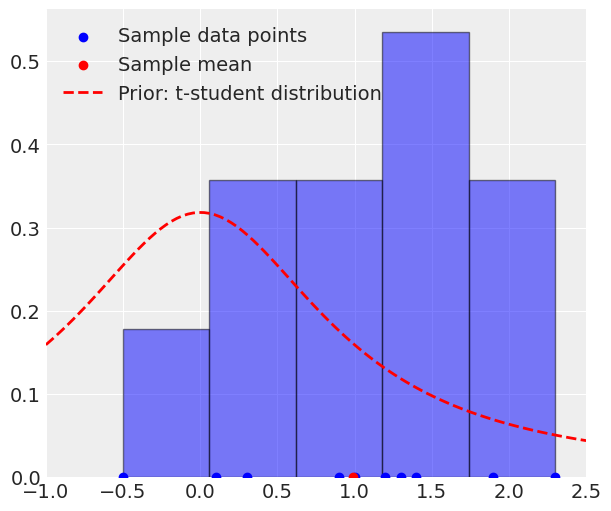

In [117]:
import matplotlib.pyplot as plt

y = [1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9]
ybar = np.mean(y)
print(f"Sample mean: {ybar}")
n = len(y)

plt.figure(figsize=(6, 5))
# plot the histogram of the data with no colors on the shape    
plt.hist(y, bins=5, density=True, color='blue', alpha=0.5, edgecolor='black');
plt.xlim(-1.0, 2.5)
# add the data points
plt.scatter( y, np.zeros(n), color='blue', marker='o', zorder=2)
# add the sample mean
plt.scatter( ybar, 0, color='red', marker='o', zorder=2)
# add to the plot a prior consisting of a t-distribution with 3 degrees of freedom

# get the x-axis
x = np.linspace(-1.0, 2.5, 100)
# make a dashed line
plt.plot(x, stats.t.pdf(x, df=1, loc=0, scale=1), color='red', linewidth=2, linestyle='dashed');
# add a legend saying that the red line is the prior
plt.legend(["Sample data points", 'Sample mean', "Prior: t-student distribution"], loc='upper left')


As one can see, there is a big discrepancy between our prior for $\mu$ and what the data says $\mu$ should be. The prior has most of its probability mass around 0, but the data says that $\mu$ should be between 1 and 1.5. We expect that the posterior distribution from $\mu$ will have a mean as a compromise somewhere between 0 and 1. Let's run the sampler.

In [118]:
# ArviZ ships with style sheets!
az.style.use("arviz-darkgrid")

#### High standard deviation

Acceptance rate: 0.116
Posterior mean:  0.9010051366811608


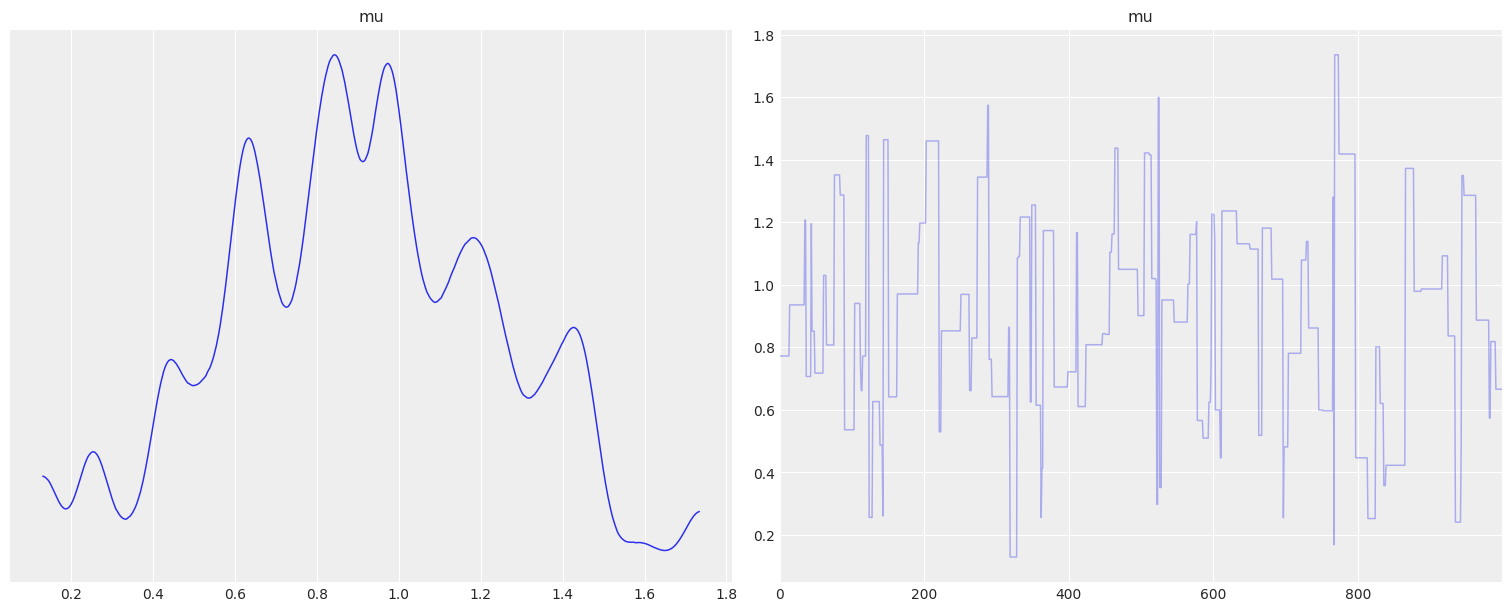

In [119]:
max_iter = 1000
mu_init = 0.0
cand_std = 3.0

# make a seed
np.random.seed(43)

output = metropolis_hastings( n, ybar, max_iter, mu_init, cand_std )

acceptance_rate = output["acceptance_rate"]
posterior = output["mu"]
print(f"Acceptance rate: {acceptance_rate}")
print(f"Posterior mean:  {np.mean(posterior)}")

# plot the posterior
az.plot_trace(output, var_names=["mu"], figsize=(15, 6));


the traceplot shows the history of our Markov Chain. It gives us some basic feedback about whether the chain has reached the stationaty distribution. It appears that our proposal step size in this case was a little too large, because we had an acceptance rate bellow 23%. 

You can see this in the traceplot. As the sampler was moving along, for example in the early iterations, $\mu$ got stuck at a single value for quite a long time. So, in other words, our Markov Chain is not moving around as much as we would like it to. So, we should increase the acceptance rate.

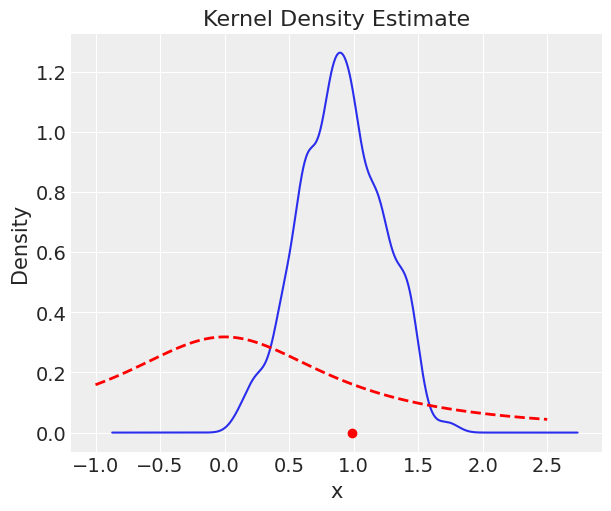

In [120]:
plot_posterior( posterior, ybar )

if we increase the variability in the distribution that creates the candidates, that will decrease the acceptance rate. Since we want to increase the acceptance rate, let's reduce it to 0.05.

#### Small standard deviation

Acceptance rate: 0.936
Posterior mean:  0.9722723395253647


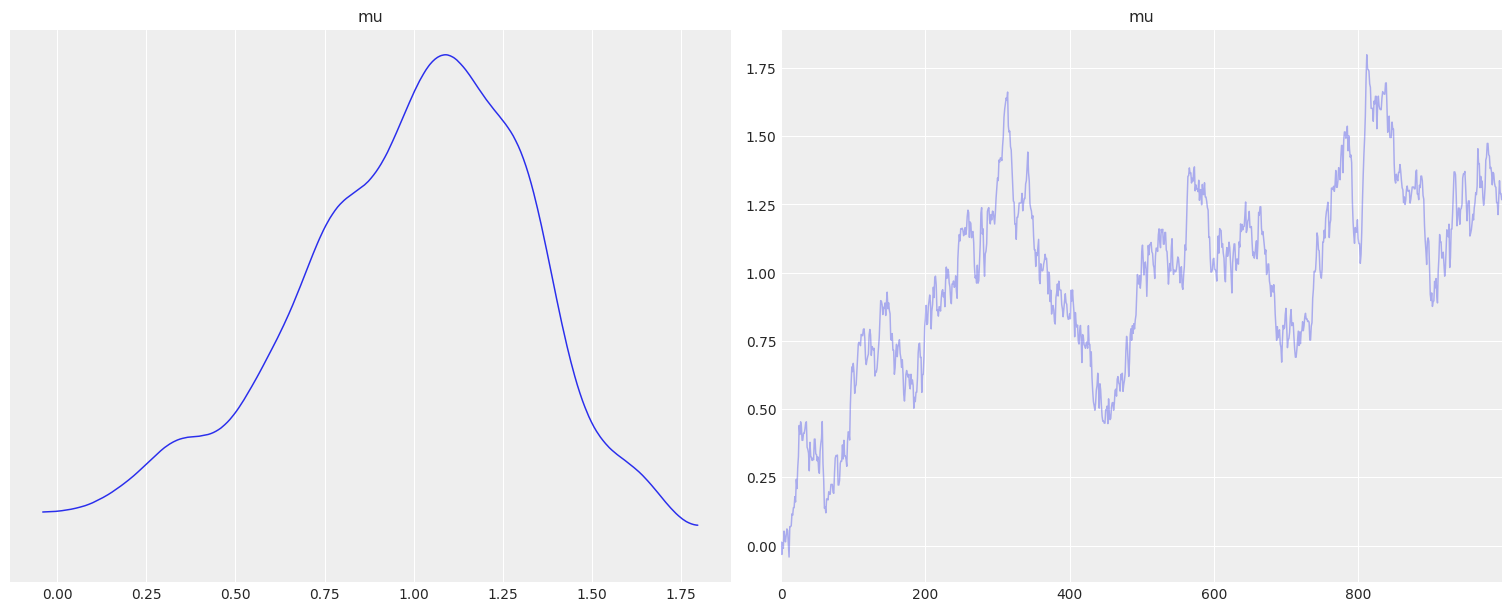

In [121]:
max_iter = 1000
mu_init = 0.0
cand_std = 0.05

# make a seed
np.random.seed(43)

output = metropolis_hastings( n, ybar, max_iter, mu_init, cand_std )

acceptance_rate = output["acceptance_rate"]
posterior = output["mu"]
print(f"Acceptance rate: {acceptance_rate}")
print(f"Posterior mean:  {np.mean(posterior)}")

az.plot_trace(output, var_names=["mu"], figsize=(15, 6));


in here, the steps are too small. It will take the chain a long time to explore the posterior distribution.

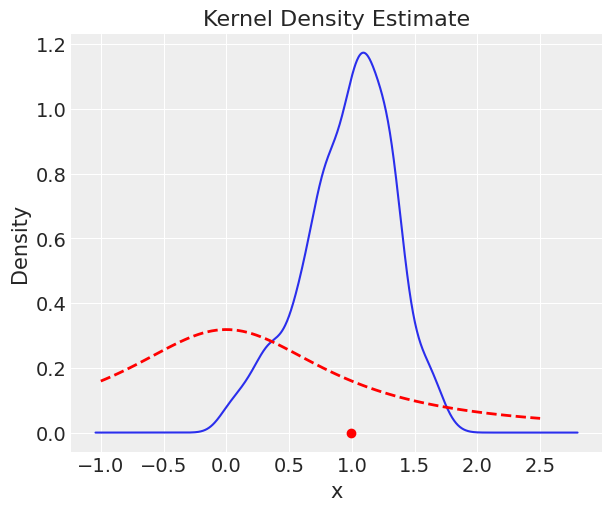

In [122]:
plot_posterior( posterior, ybar )

#### Average standard deviation

Acceptance rate: 0.384
Posterior mean:  0.8947112654425837


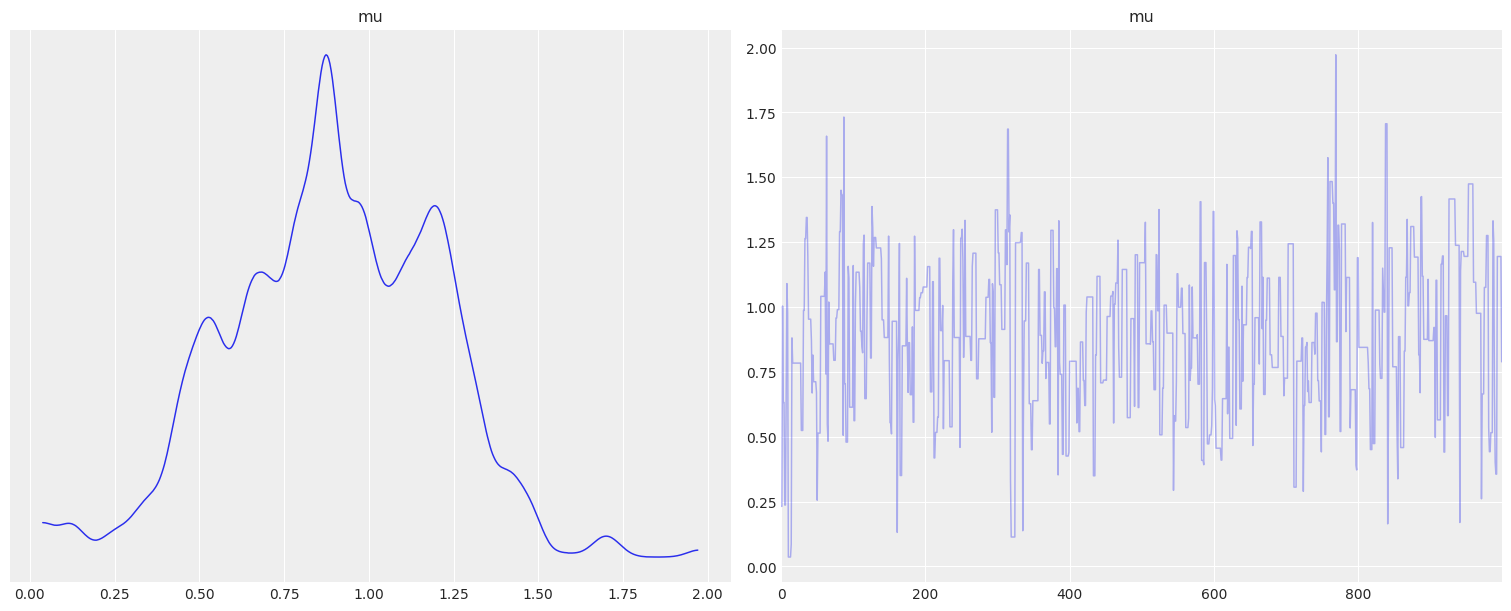

In [123]:
max_iter = 1000
mu_init = 0.0
cand_std = 0.9

# make a seed
np.random.seed(43)

output = metropolis_hastings( n, ybar, max_iter, mu_init, cand_std )

acceptance_rate = output["acceptance_rate"]
posterior = output["mu"]
print(f"Acceptance rate: {acceptance_rate}")
print(f"Posterior mean:  {np.mean(posterior)}")

az.plot_trace(output, var_names=["mu"], figsize=(15, 6));


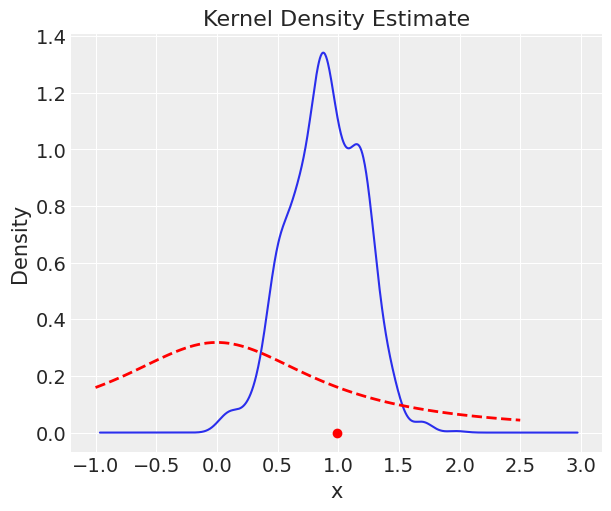

In [124]:
plot_posterior( posterior, ybar )

#### High initial value

let's see what happens if we change the initial value

Acceptance rate: 0.38
Posterior mean:  1.0564408015111526


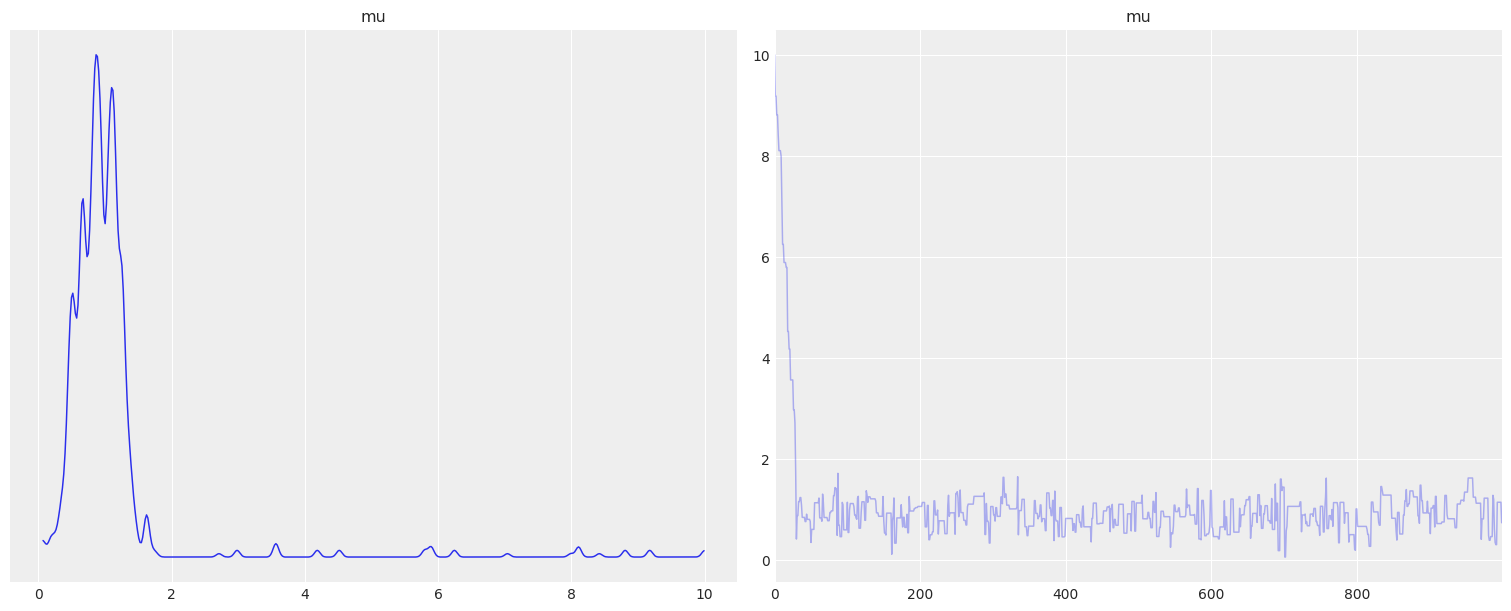

In [142]:
max_iter = 1000
mu_init = 10.0
cand_std = 0.9

# make a seed
np.random.seed(43)

output = metropolis_hastings( n, ybar, max_iter, mu_init, cand_std )

acceptance_rate = output["acceptance_rate"]
posterior = output["mu"]
print(f"Acceptance rate: {acceptance_rate}")
print(f"Posterior mean:  {np.mean(posterior)}")

az.plot_trace(output, var_names=["mu"], figsize=(15, 6));


this is what happens when we have an exaggerated initial value. The chain is going to take a long time to explore the posterior distribution.

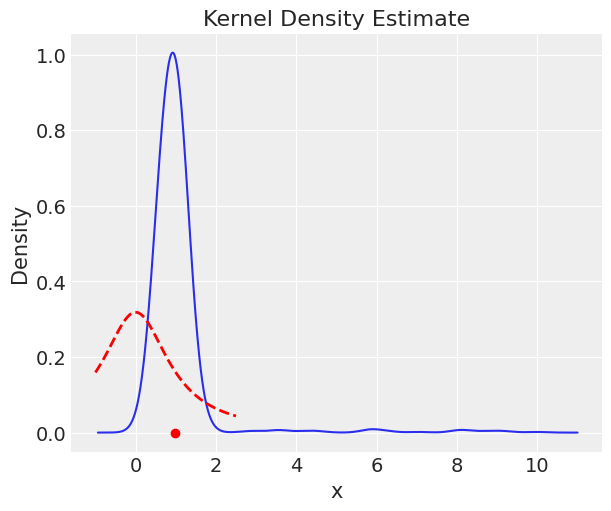

In [143]:
plot_posterior( posterior, ybar )

#### Discarding the first 100 interations

Posterior mean:  0.9037217654997838


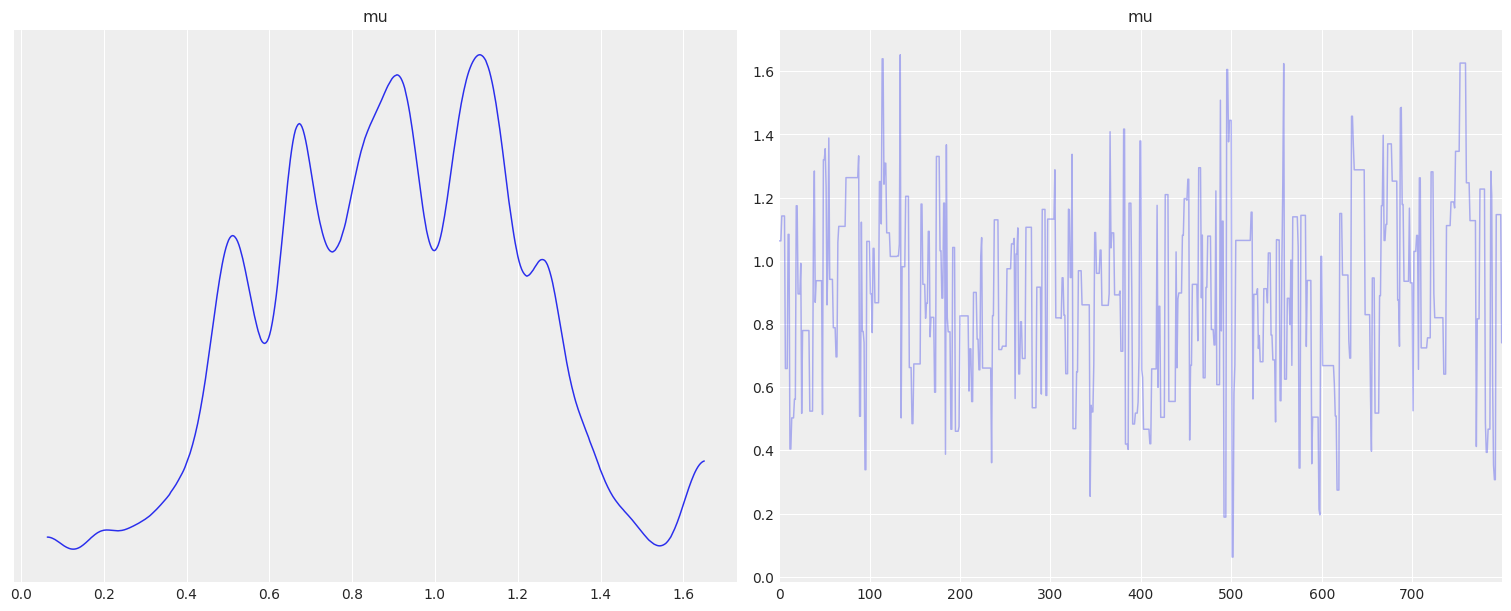

In [144]:
output["mu"] = output["mu"][200:]
posterior = output["mu"]

print(f"Posterior mean:  {np.mean(posterior)}")
az.plot_trace(output, var_names=["mu"], figsize=(15, 6));


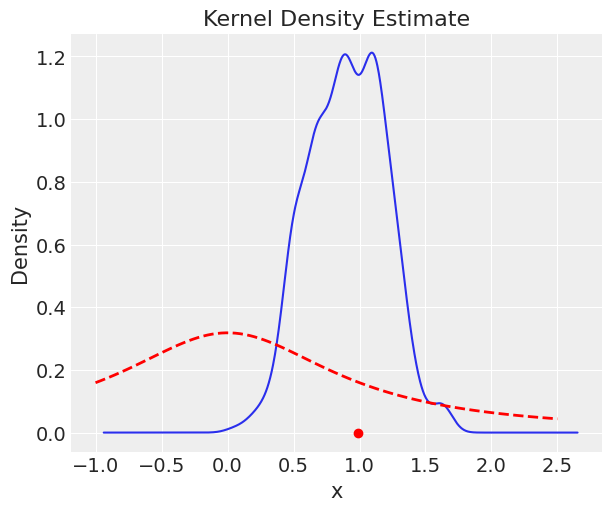

In [145]:
plot_posterior( posterior, ybar )